In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
url = '/content/sample_data/Filtered_Phenotypic_Data.csv'  # Replace with your file path or URL
data = pd.read_csv(url)

# Identify non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()

# Extract non-numeric columns before dropping them
data_non_numeric = data[non_numeric_cols]

# Drop the non-numeric columns from the main DataFrame
data.drop(non_numeric_cols, axis=1, inplace=True)

# Encode the non-numeric values using one-hot encoding
data_non_numeric_encoded = pd.get_dummies(data_non_numeric, columns=non_numeric_cols)

# Concatenate the encoded non-numeric data with the numeric data
data = pd.concat([data, data_non_numeric_encoded], axis=1)

# Separate features (X) and target variable (y)
X = data.drop(columns=['DX_GROUP'])
y = data['DX_GROUP']

# Encode the target variable if necessary
if y.dtype == 'object' or y.dtype.name == 'category':
    y = LabelEncoder().fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input to 3D for BiLSTM [samples, timesteps, features]
# Assuming 1 timestep as we are not working with sequential data
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Check shapes
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


X_train shape: (707, 1, 902)
X_test shape: (177, 1, 902)
y_train shape: (707,)
y_test shape: (177,)


In [3]:
# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))  # Use 'softmax' if you have multiple classes

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
23/23 [==============================] - 5s 54ms/step - loss: 0.0521 - accuracy: 0.4540 - val_loss: -0.9428 - val_accuracy: 0.4746
Epoch 2/50
23/23 [==============================] - 0s 11ms/step - loss: -0.4267 - accuracy: 0.4583 - val_loss: -2.3458 - val_accuracy: 0.4746
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: -1.1132 - accuracy: 0.4583 - val_loss: -4.7477 - val_accuracy: 0.4746
Epoch 4/50
23/23 [==============================] - 0s 10ms/step - loss: -2.3471 - accuracy: 0.4583 - val_loss: -9.4993 - val_accuracy: 0.4746
Epoch 5/50
23/23 [==============================] - 0s 13ms/step - loss: -5.3216 - accuracy: 0.4583 - val_loss: -19.7850 - val_accuracy: 0.4746
Epoch 6/50
23/23 [==============================] - 0s 11ms/step - loss: -12.5748 - accuracy: 0.4583 - val_loss: -39.2324 - val_accuracy: 0.4746
Epoch 7/50
23/23 [==============================] - 0s 10ms/step - loss: -27.3148 - accuracy: 0.4583 - val_loss: -69.1674 - val_accuracy: 0.

6/6 [==============================] - 0s 17ms/step
Accuracy: 47.46%
Classification Report:
               precision    recall  f1-score   support

           1       0.47      1.00      0.64        84
           2       0.00      0.00      0.00        93

    accuracy                           0.47       177
   macro avg       0.24      0.50      0.32       177
weighted avg       0.23      0.47      0.31       177



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


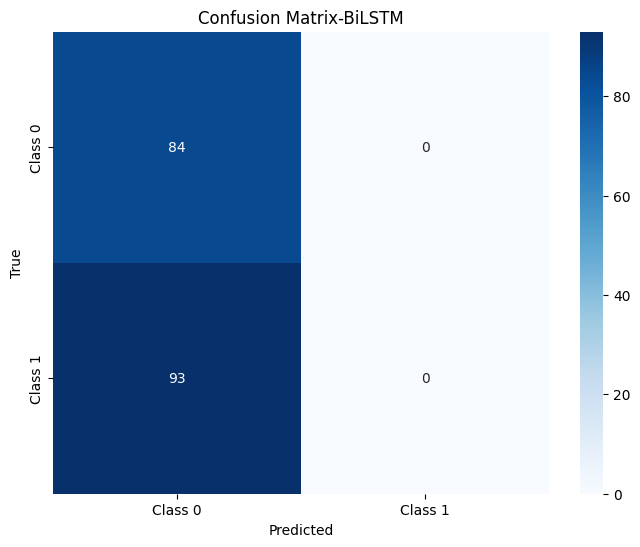

Precision: 0.22522263717322608
Recall: 0.4745762711864407
F1 Score: 0.30547438145334116


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype("int32")  # Convert probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
class_report = classification_report(y_test, y_pred_class)
print('Classification Report:\n', class_report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_class)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix-BiLSTM')
plt.show()

# Calculate additional metrics
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


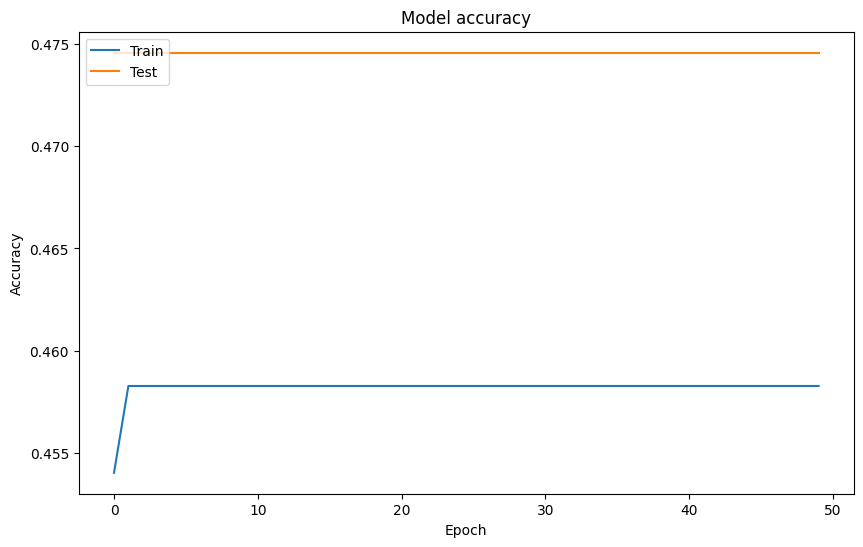

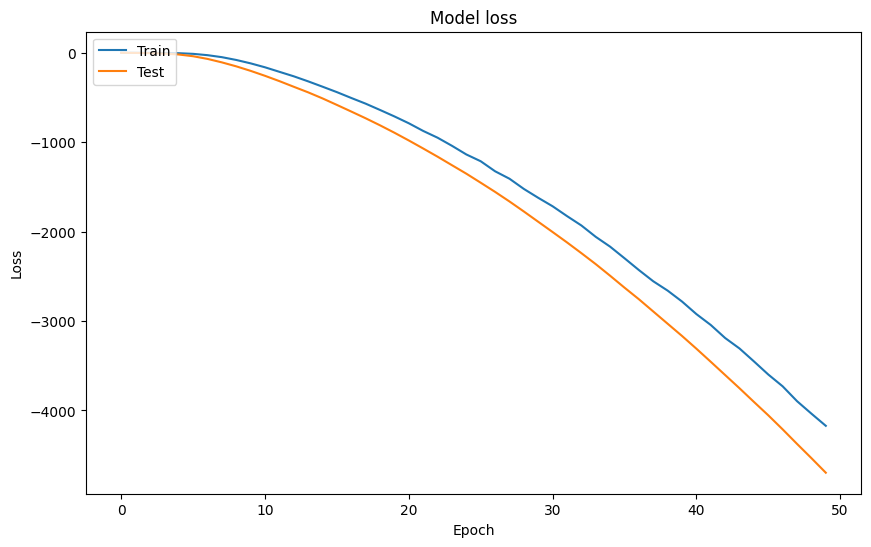

In [5]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
